In [2]:
# Import libraries and magics
import numpy as np
import numpy.random as npr
import scipy.stats as stats
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interactive
from tqdm import trange
from sympy import oo #INFINITY
%matplotlib inline
plt.style.use('bmh')

In [54]:
#Parse CSV
#df = pd.read_csv('360Roll_3Dir.csv');
#df = pd.read_csv('testdata.csv');
df = pd.read_csv('360Roll_3Dir.csv')
df['t'] = (df['t'] - df['t'][0])/1000000 #start t at 0, convert to s
df['dt'] = 0
df

,t,aX,aY,aZ,gX,gY,gZ,mX,mY,mZ,dt
0,0.000000,0.00,-0.03,1.00,0.03,-0.06,0.02,38.90,-3.53,-28.77,0
1,0.043520,0.01,-0.03,1.01,0.39,0.25,0.08,39.00,-3.87,-28.91,0
2,0.093325,0.00,-0.04,0.99,0.33,0.25,0.20,38.54,-3.61,-29.41,0
3,0.143396,0.01,-0.03,1.00,0.27,0.31,0.14,38.72,-3.19,-28.80,0
4,0.193151,0.00,-0.03,1.00,0.33,0.25,0.14,38.70,-3.63,-28.83,0
...,...,...,...,...,...,...,...,...,...,...,...
600,29.877472,-0.02,0.02,1.03,0.09,1.17,0.02,38.10,-4.41,-28.69,0
601,29.926552,-0.01,0.03,1.01,-1.68,-0.24,-0.35,38.89,-4.61,-29.08,0
602,29.977448,-0.03,0.05,0.97,-0.77,-1.22,-1.14,38.50,-4.25,-28.98,0
603,30.027470,-0.01,0.03,0.99,-2.11,2.26,-1.08,38.82,-4.72,-29.27,0


In [55]:
#Calculate dt, get radian angles
for i in range(1,df.shape[0]):
    df.loc[i,'dt'] = (df['t'][i])-(df['t'][i-1])
for i in range(df.shape[0]):
    df.loc[i,'gXr'] = np.deg2rad(df['gX'][i])
    df.loc[i,'gYr'] = np.deg2rad(df['gY'][i])
    df.loc[i,'gZr'] = np.deg2rad(df['gZ'][i])
df

,t,aX,aY,aZ,gX,gY,gZ,mX,mY,mZ,dt,gXr,gYr,gZr
0,0.000000,0.00,-0.03,1.00,0.03,-0.06,0.02,38.90,-3.53,-28.77,0.000000,0.000524,-0.001047,0.000349
1,0.043520,0.01,-0.03,1.01,0.39,0.25,0.08,39.00,-3.87,-28.91,0.043520,0.006807,0.004363,0.001396
2,0.093325,0.00,-0.04,0.99,0.33,0.25,0.20,38.54,-3.61,-29.41,0.049805,0.005760,0.004363,0.003491
3,0.143396,0.01,-0.03,1.00,0.27,0.31,0.14,38.72,-3.19,-28.80,0.050071,0.004712,0.005411,0.002443
4,0.193151,0.00,-0.03,1.00,0.33,0.25,0.14,38.70,-3.63,-28.83,0.049755,0.005760,0.004363,0.002443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,29.877472,-0.02,0.02,1.03,0.09,1.17,0.02,38.10,-4.41,-28.69,0.050790,0.001571,0.020420,0.000349
601,29.926552,-0.01,0.03,1.01,-1.68,-0.24,-0.35,38.89,-4.61,-29.08,0.049080,-0.029322,-0.004189,-0.006109
602,29.977448,-0.03,0.05,0.97,-0.77,-1.22,-1.14,38.50,-4.25,-28.98,0.050896,-0.013439,-0.021293,-0.019897
603,30.027470,-0.01,0.03,0.99,-2.11,2.26,-1.08,38.82,-4.72,-29.27,0.050022,-0.036826,0.039444,-0.018850


In [56]:
#Calculate orientation using Madgwick Filter
from ahrs.ahrs.filters import Madgwick
angles = Madgwick()
Q = np.tile([1., 0., 0., 0.],(df.shape[0], 1)) # Allocate for quaternions
for i in range(1,df.shape[0]):
    Q[i] = angles.updateMARG(Q[i-1], gyr=(df.loc[i].to_numpy())[11:], acc=(df.loc[i].to_numpy())[1:4], mag=(df.loc[i].to_numpy())[11:], dt= np.mean(df['dt']))

In [57]:
#Convert Quaternion states into euler angles
from ahrs.ahrs.common import Quaternion
xAngles = []
yAngles = []
zAngles = []
for i in range(df.shape[0]):
    xyzAngles = np.rad2deg(Quaternion(Q[i]).to_angles())
    xAngles += [xyzAngles[0]]
    yAngles += [xyzAngles[1]]
    zAngles += [xyzAngles[2]]

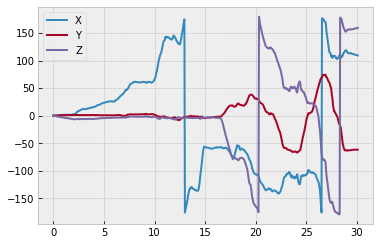

In [58]:
#Plot euler angle displacement
plt.plot(df['t'],xAngles,label='X')
plt.plot(df['t'],yAngles,label='Y')
plt.plot(df['t'],zAngles, label='Z')

plt.legend()

In [60]:
#Convert relative XYZ to global XYZ
xAccGlobal = []
yAccGlobal = []
zAccGlobal = []
for i in range(df.shape[0]):
    magnitude = (df['aX'][i])**2 + (df['aY'][i])**2 + (df['aZ'][i])**2
    #TODO: HANDLE REMOVAL OF GRAVITY
    xAccGlobal += [magnitude * np.cos(xAngles[i])]
    yAccGlobal += [magnitude * np.cos(yAngles[i])]
    zAccGlobal += [(magnitude * np.cos(zAngles[i]))]

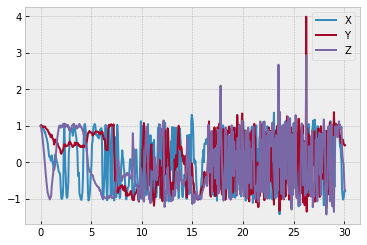

In [61]:
#Plot acceleration
plt.plot(df['t'],xAccGlobal,label='X')
plt.plot(df['t'],yAccGlobal,label='Y')
plt.plot(df['t'],zAccGlobal, label='Z')

plt.legend()

In [62]:
#Calculate velocity
xVel = [0]
yVel = [0]
zVel = [0]
for i in range(1,df.shape[0]):
    xVel += [xVel[i-1] + xAccGlobal[i-1] * df['dt'][i]]
    yVel += [yVel[i-1] + yAccGlobal[i-1] * df['dt'][i]]
    zVel += [zVel[i-1] + zAccGlobal[i-1] * df['dt'][i]]

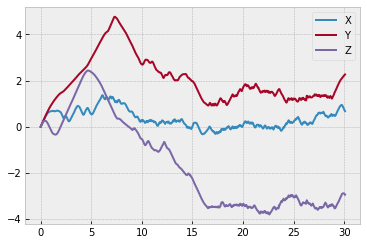

In [63]:
#Plot velocity
plt.plot(df['t'],xVel,label='X')
plt.plot(df['t'],yVel,label='Y')
plt.plot(df['t'],zVel, label='Z')
plt.legend()

In [46]:
xVel

[0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
